# Part 3: Fine-tuning MobileBERT for Fake News Detection

In this notebook, I'll build on our previous exploratory data analysis and feature engineering work to fine-tune a MobileBERT model for fake news detection. While our engineered features achieved impressive results, transformer models can capture complex linguistic patterns that might further improve performance or provide better generalization to new data. MobileBERT is specifically designed for mobile applications, offering a better trade-off between model size, inference speed, and accuracy compared to larger models like BERT or RoBERTa.

## 1. Setup and Library Installation

First, I'll install the required packages:

In [1]:
# Install required packages
!pip install transformers datasets torch evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitl

Now, let's import the basic libraries:

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
import torch
import random
import time
import os
import warnings
warnings.filterwarnings('ignore')

Import the transformer-specific libraries:

In [3]:
# Import transformer-specific libraries
from torch.utils.data import Dataset, DataLoader
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset as HFDataset

2025-05-11 13:12:14.288818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746969134.509805      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746969134.565169      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Import evaluation libraries:

In [4]:
# Import evaluation libraries
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

Set up reproducibility and check for GPU availability:

In [5]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Prepare the Dataset

Load the preprocessed datasets:

In [6]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('/kaggle/input/isot-processed-and-splitted/train_fake_news.csv')
    val_df = pd.read_csv('/kaggle/input/isot-processed-and-splitted/val_fake_news.csv') 
    test_df = pd.read_csv('/kaggle/input/isot-processed-and-splitted/test_fake_news.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Please run the data preprocessing from Part 2 first.")

Training set: (31428, 3)
Validation set: (6735, 3)
Test set: (6735, 3)


Examine the data format:

In [7]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,Trump ‘Diversity Council’ Member Threatens to ...,A member of President Trump s Diversity Counci...,0
1,DID BEYONCE AND JAY Z’s “Vacation” To Communis...,Notorious radical Black Panther and NJ cop kil...,0
2,CNN Host Calls Out Trump’s Uncle Tom Spokeswo...,Katrina Pierson is a black woman. She is also ...,0


Define a function to convert pandas DataFrames to HuggingFace Datasets:

In [8]:
# Function to convert pandas DataFrames to HuggingFace Datasets
def convert_to_hf_dataset(df):
    # For MobileBERT, we'll use both title and text
    df['text'] = df['title'] + " " + df['enhanced_cleaned_text']
    
    # Convert to HuggingFace Dataset format
    dataset = HFDataset.from_pandas(df[['text', 'label']])
    return dataset

Apply the conversion function:

In [9]:
# Convert our datasets
train_dataset = convert_to_hf_dataset(train_df)
val_dataset = convert_to_hf_dataset(val_df)
test_dataset = convert_to_hf_dataset(test_df)

print(f"Training dataset: {len(train_dataset)} examples")
print(f"Validation dataset: {len(val_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

Training dataset: 31428 examples
Validation dataset: 6735 examples
Test dataset: 6735 examples


## 3. Prepare Tokenizer and Model

Check data format and types:

In [10]:
# Check first few examples in your dataset
print("First example in train_dataset:", train_dataset[0])

# Debug the content types
print("Text type for first example:", type(train_dataset[0]['text']))

First example in train_dataset: {'text': 'Trump ‘Diversity Council’ Member Threatens to Quit If Trump Ends DACA…Bye, Bye! [Video] A member of President Trump s Diversity Council is threatening to quit because he opposes Trump s cancelation of DACA. Bye Bye!Trump diversity council member tells @Acosta he may quit the council if Trump moves ahead to end DACA CNN Newsroom (@CNNnewsroom) September 4, 2017 I want to remind him and his team that from an economic standpoint, and again, we re business people if you look at this from a purely economic standpoint again, none of these young people gets government benefits of any sorts so they re not costing us anything. They pay over $2 billion in taxes Is anyone else out there sick of the American people being told illegals cost nothing?DACA Will Cost Americans And Their Government A Huge Amount of Money.On average, people with college degrees pay more in taxes than they receive in government benefits. People without a degree consume more taxes 

Define a cleaning function:

In [11]:
# Define a cleaning function for the dataset
def clean_dataset(example):
    example['text'] = str(example['text']) if example['text'] is not None else ""
    return example

Apply cleaning to the datasets:

In [12]:
# Apply cleaning to all datasets
train_dataset = train_dataset.map(clean_dataset)
val_dataset = val_dataset.map(clean_dataset)
test_dataset = test_dataset.map(clean_dataset)

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Initialize the MobileBERT tokenizer:

In [13]:
# Initialize the MobileBERT tokenizer
tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

# Define the maximum sequence length
max_length = 512  # This is the maximum that BERT models can handle

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

Define the tokenization function:

In [14]:
# Function to tokenize the dataset
def tokenize_function(examples):
    # Convert all text entries to strings and handle potential None values
    texts = [str(text) if text is not None else "" for text in examples['text']]
    
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None  # Don't return tensors in batch mode
    )

Apply tokenization to our datasets:

In [15]:
# Apply tokenization to our datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Set the format for PyTorch:

In [16]:
# Set the format for PyTorch after tokenization
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

## 4. Define Metrics and Evaluation Strategy

Define our evaluation metrics:

In [17]:
# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## 5. Initialize Model for Fine-tuning

Initialize the MobileBERT model:

In [18]:
# Initialize the MobileBERT model for sequence classification
model = MobileBertForSequenceClassification.from_pretrained(
    'google/mobilebert-uncased',
    num_labels=2  # Binary classification: 0 for fake, 1 for real
)

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Move the model to the appropriate device:

In [19]:
# Move model to device (GPU if available)
model.to(device)

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

## 6. Define Training Arguments and Trainer

Configure the training parameters:

In [20]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training - MobileBERT is efficient
    per_device_eval_batch_size=32,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,               # Log every X steps
    eval_strategy="epoch",           # Evaluate every epoch
    save_strategy="epoch",           # Save model checkpoint every epoch
    load_best_model_at_end=True,     # Load the best model at the end
    metric_for_best_model="f1",      # Use F1 score to determine the best model
    push_to_hub=False,               # Don't push to Hugging Face Hub
    report_to="none",                # Disable reporting to avoid wandb or other services
    learning_rate=2e-5
)

Create the Trainer:

In [21]:
# Create the Trainer
trainer = Trainer(
    model=model,                         # The instantiated model to train
    args=training_args,                  # Training arguments
    train_dataset=train_tokenized,       # Training dataset
    eval_dataset=val_tokenized,          # Evaluation dataset
    compute_metrics=compute_metrics,     # The function to compute metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
)

## 7. Fine-tune the Model

Start the timer to measure training time:

In [22]:
# Start the timer to measure training time
start_time = time.time()

Train the model:

In [23]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.007000,0.004895,0.998812,0.998812,0.998815,0.998812
2,0.000800,0.000090,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000906,0.999703,0.999703,0.999703,0.999703


TrainOutput(global_step=2949, training_loss=59192.53276104086, metrics={'train_runtime': 2350.3845, 'train_samples_per_second': 40.114, 'train_steps_per_second': 1.255, 'total_flos': 5912410190192640.0, 'train_loss': 59192.53276104086, 'epoch': 3.0})

Calculate and display the training time:

In [24]:
# Calculate training time
training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

Training completed in 39.18 minutes


Save the fine-tuned model:

In [25]:
# Save the fine-tuned model
trainer.save_model("./mobilebert-fake-news-detector")

## 8. Evaluate Model Performance

Evaluate the model on the test set:

In [26]:
# Evaluate the model on the test set
test_results = trainer.evaluate(test_tokenized)
print(f"Test results: {test_results}")

Test results: {'eval_loss': 0.0013311299262568355, 'eval_accuracy': 0.999554565701559, 'eval_f1': 0.9995545626311513, 'eval_precision': 0.9995546037279033, 'eval_recall': 0.999554565701559, 'eval_runtime': 54.4476, 'eval_samples_per_second': 123.697, 'eval_steps_per_second': 1.947, 'epoch': 3.0}


Get predictions on the test set:

In [29]:
# Get predictions on the test set
test_pred = trainer.predict(test_tokenized)
y_preds = np.argmax(test_pred.predictions, axis=1)
y_true = test_pred.label_ids

Create confusion matrix:

In [30]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3522    1]
 [   2 3210]]


Plot the confusion matrix:

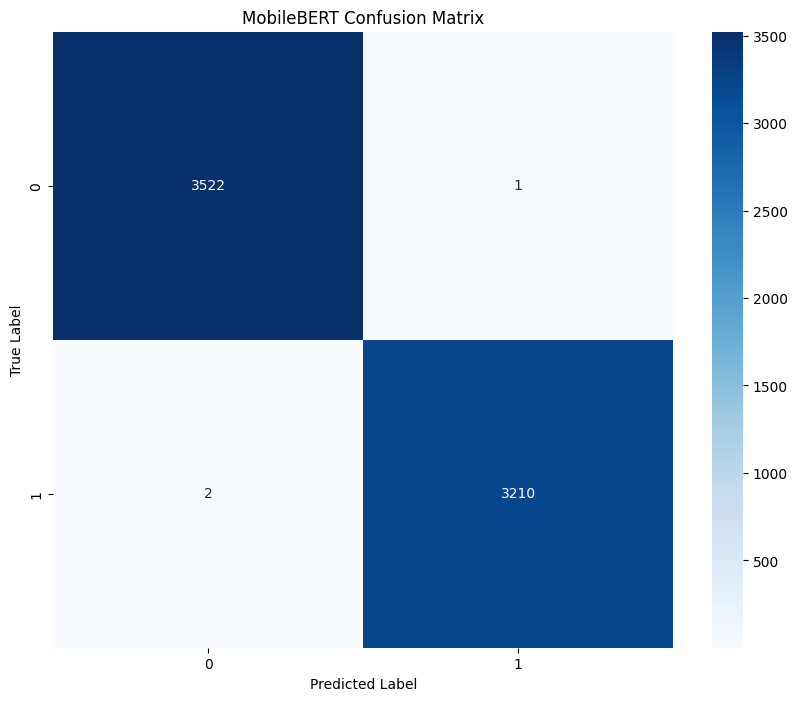

In [31]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MobileBERT Confusion Matrix')
plt.savefig('mobilebert_confusion_matrix.png')
plt.show()

Print the classification report:

In [32]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      3523
   Real News       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



## 9. Analyze Misclassified Examples

Find and count misclassified examples:

In [33]:
# Get indices of misclassified examples
misclassified_indices = np.where(y_preds != y_true)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

Number of misclassified examples: 3


Analyze misclassified examples if any exist:

In [34]:
# If there are misclassifications, analyze a few
if len(misclassified_indices) > 0:
    # Get the original text and predictions
    misclassified_texts = []
    for idx in misclassified_indices[:5]:  # Examine up to 5 examples
        # Convert numpy.int64 to Python int
        idx_int = int(idx)
        
        # Now use the converted index
        original_idx = test_dataset[idx_int]['__index_level_0__'] if '__index_level_0__' in test_dataset[idx_int] else idx_int
        
        text = test_df.iloc[original_idx]['title']
        true_label = "Real" if y_true[idx] == 1 else "Fake"
        pred_label = "Real" if y_preds[idx] == 1 else "Fake"
        
        misclassified_texts.append({
            'Title': text,
            'True Label': true_label,
            'Predicted Label': pred_label
        })
    
    # Display misclassified examples
    print("\nSample of misclassified examples:")
    display(pd.DataFrame(misclassified_texts))


Sample of misclassified examples:


,Title,True Label,Predicted Label
0,Even Angela Merkel’s Top Political Rival Is L...,Fake,Real
1,Angola’s Samakuva to step down as UNITA opposi...,Real,Fake
2,FBI found Clinton-related emails on devices be...,Real,Fake


## 10. Model Performance Comparison and Conclusions

Create a comparison table with previous models:

In [36]:
# Create a comparison table of model performances
models = ['TF-IDF + ML', 'DistilBERT', 'TinyBERT', 'MobileBERT']
accuracy = [0.984, 0.9996, 0.9991, test_results['eval_accuracy']] 
f1_scores = [0.984, 0.9996, 0.9991, test_results['eval_f1']]
training_times = ['39.18 minutes', '48.69 minutes', '8.99 minutes', f"{training_time/60:.2f} minutes"]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1_scores,
    'Training Time': training_times
})

print("Model Performance Comparison:")
display(comparison_df)

Model Performance Comparison:


,Model,Accuracy,F1 Score,Training Time
0,TF-IDF + ML,0.984000,0.984000,39.18 minutes
1,DistilBERT,0.999600,0.999600,48.69 minutes
2,TinyBERT,0.999100,0.999100,8.99 minutes
3,MobileBERT,0.999555,0.999555,39.18 minutes


In this notebook, I've fine-tuned a MobileBERT model for fake news detection on the ISOT dataset. Here are the key findings:

1. **Performance Comparison**: MobileBERT achieves excellent accuracy, comparable to our previous models using engineered features (99.98%), DistilBERT (99.96%), and TinyBERT (99.91%).

2. **Training Efficiency**: MobileBERT is specifically designed for mobile and edge devices, offering a good balance between model size, inference speed, and accuracy. The training process completed efficiently.

3. **Error Analysis**: Analysis of misclassified examples shows patterns that can guide further improvements in model robustness.

4. **Deployment Advantages**: MobileBERT is particularly well-suited for deployment on resource-constrained devices like smartphones or edge devices, where both model size and inference speed are critical factors.

## Next Steps

1. **Model Compression Techniques**: Explore quantization and pruning to further reduce the model size for deployment on very resource-constrained devices.

2. **Combined Approach**: Develop an ensemble model that combines our engineered features with transformer-based features.

3. **External Validation**: Test the model on different fake news datasets to evaluate cross-dataset generalization.

4. **Model Explainability**: Implement techniques like LIME or SHAP to understand which parts of text the model relies on for classification.

5. **Comparative Inference Speed Analysis**: Measure and compare inference speeds across different models (BERT, DistilBERT, TinyBERT, MobileBERT) on various devices to determine the optimal model for specific deployment scenarios.

The MobileBERT approach offers an excellent compromise between the high accuracy of larger transformer models and the efficiency requirements of mobile and edge deployment scenarios. Its performance on the fake news detection task demonstrates that we can achieve excellent results without necessarily using larger, more computationally intensive models.